# Motor Score (UPDRS) analysis of PPMI 


In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [2]:
path2 = Path("/scratch/znazari/PPMI_ver_sep2022/study_data/motor_score")
path_ = Path("/home/znazari/data/")# the path to the saved data

In [3]:
# Display all the file in the motor_score folder of study_data of PPMI
content_list = os.listdir(path2)
content_list

['MDS_UPDRS_Part_II__Patient_Questionnaire.csv',
 'Neuro_QoL__Lower_Extremity_Function__Mobility__-_Short_Form.csv',
 'Gait_Data___Arm_swing.csv',
 'MDS-UPDRS_Part_I_Patient_Questionnaire.csv',
 'MDS-UPDRS_Part_IV__Motor_Complications.csv',
 'MDS-UPDRS_Part_I.csv',
 'Modified_Schwab___England_Activities_of_Daily_Living.csv',
 'MDS-UPDRS_Part_III_ON_OFF_Determination___Dosing.csv',
 'Participant_Motor_Function_Questionnaire.csv',
 'MDS_UPDRS_Part_III.csv',
 'Neuro_QoL__Upper_Extremity_Function_-_Short_Form.csv',
 'PPMI_Methods_Gait_AM0180319.pdf']

Take the final total score of UPDRS part I, II, III

In [4]:
motor_score_main = pd.read_csv(path_/"intersect_PatNo_MDS_UPDRS_I_Ipat_IIpat_III_TotScores_only_BL_no_empty_Class_PD_HC_no_UR_value.txt",delimiter='\t')

In [5]:
motor_score_part1 = pd.read_csv(path2/"MDS-UPDRS_Part_I_Patient_Questionnaire.csv",delimiter=',')

motor_score_part1

,REC_ID,PATNO,EVENT_ID,PAG_NAME,INFODT,NUPSOURC,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,ORIG_ENTRY,LAST_UPDATE
0,272451501,3000,BL,NUPDRS1P,02/2011,1,1.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,02/2011,2020-06-25 16:02:19.0
1,338702301,3000,V04,NUPDRS1P,03/2012,1,0.0,2.0,0.0,1.0,0.0,0.0,1.0,4.0,03/2012,2020-06-25 16:02:21.0
2,385009201,3000,V06,NUPDRS1P,02/2013,1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,02/2013,2020-06-25 16:02:22.0
3,437130801,3000,V08,NUPDRS1P,03/2014,1,3.0,2.0,0.0,1.0,0.0,0.0,0.0,6.0,05/2014,2020-06-25 16:02:22.0
4,512466901,3000,V10,NUPDRS1P,03/2015,1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6.0,03/2015,2020-06-25 16:02:23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16563,66c0ebc7-c64c-429a-ad8c-a32507be75b5,160040,BL,NUPDRSP,07/2022,1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,08/2022,2022-08-04 00:00:00.0
16564,c6916457-e5fa-47f0-bed9-250c70200062,160231,BL,NUPDRSP,07/2022,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,08/2022,2022-08-09 00:00:00.0
16565,d7cdaa2b-03cb-4ab5-8070-29d92a865480,161236,BL,NUPDRSP,07/2022,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,08/2022,2022-08-11 00:00:00.0
16566,084df822-0092-4728-a057-3158707dfc0d,162140,BL,NUPDRSP,08/2022,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,08/2022,2022-08-18 00:00:00.0


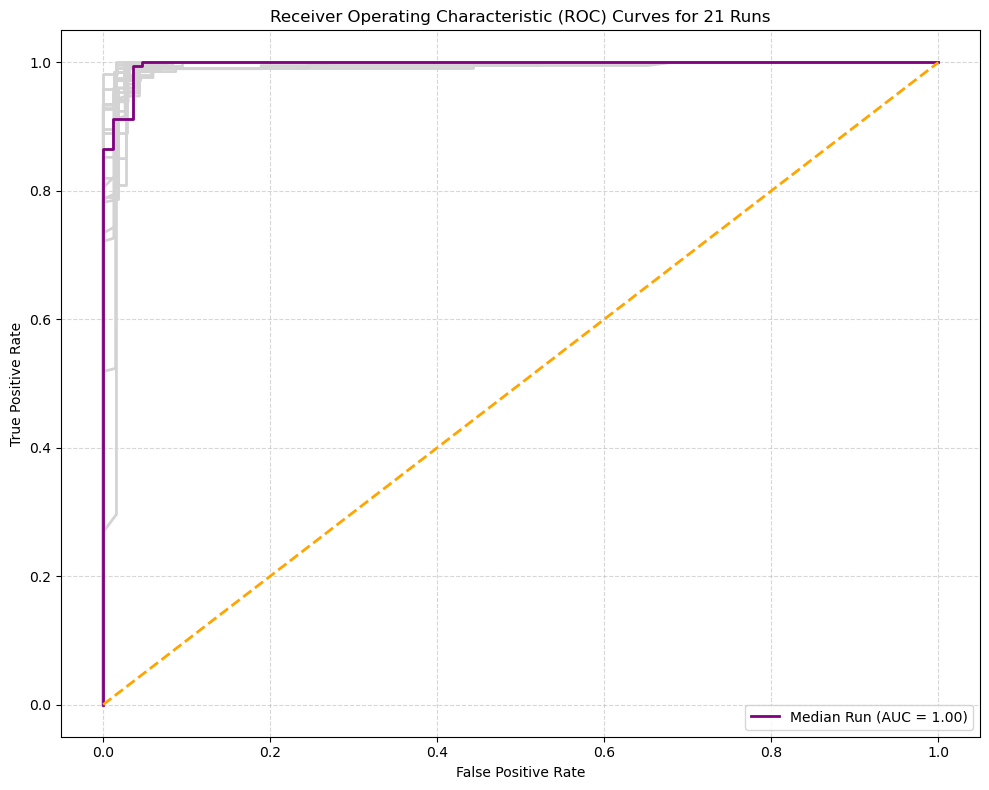

In [14]:
# ML on the final data file 

# Separate features (X) and target variable (y)
X = motor_score_main[['NP1RTOT', 'NP1PTOT', 'NP2PTOT','NP3TOT']]
y = motor_score_main['Class']

# Convert diagnosis labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Set the number of runs
num_runs = 21

# Initialize lists to store AUC scores and fpr, tpr values for each run
auc_scores = []
all_fpr, all_tpr = [], []

# Plot all ROC curves with grey plots first
plt.figure(figsize=(10, 8))
for i in range(num_runs):
    seed = i + 1  # Use different seeds
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=seed)

    # Initialize and train the XGBoost model
    xgb_model = XGBClassifier(random_state=seed, n_jobs=-1, max_depth=3)  # Add your parameters here
    xgb_model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc_score)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

    # If not the last run, plot a grey curve
    if i != num_runs - 1:
        color = 'lightgrey'
        plt.plot(all_fpr[i], all_tpr[i], lw=2, color=color)

# Find the index of the plot with the median AUC score
median_index = np.argsort(auc_scores)[num_runs // 2]

# Plot the median curve in blue
plt.plot(all_fpr[median_index], all_tpr[median_index], lw=2, color='purple', label=f'Median Run (AUC = {auc_scores[median_index]:.2f})')

plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for 21 Runs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [7]:
motor_score_1 = pd.read_csv(path2/"MDS-UPDRS_Part_I.csv",delimiter=',')

In [8]:
motor_score_2 = pd.read_csv(path2/"MDS_UPDRS_Part_II__Patient_Questionnaire.csv",delimiter=',')

In [9]:
motor_score_3 = pd.read_csv(path2/"MDS_UPDRS_Part_III.csv",delimiter=',', low_memory=False)

In [10]:
motor_score_4 = pd.read_csv(path2/"MDS-UPDRS_Part_IV__Motor_Complications.csv",delimiter=',', low_memory=False)

In [11]:
motor_score_5 = pd.read_csv(path2/"Participant_Motor_Function_Questionnaire.csv",delimiter=',', low_memory=False)

In [12]:
# Extract rows with 'BL' in the 'EVENT_ID' column
filtered_data = motor_score_1[motor_score_1['EVENT_ID'].str.contains('BL')]

# Select only the 'PATNO' and 'NP1RTOT' columns
columns_=['PATNO', 'NP1COG','NP1HALL','NP1DPRS','NP1ANXS','NP1APAT','NP1DDS']
result = filtered_data[columns_]

In [13]:
# Get the current date
current_date = datetime.now().date()

# Print the current date
print("Last update :", current_date)

Last update : 2024-02-29
